In [1]:
import numpy as np
import gymnasium as gym
import scipy

In [2]:
g = 9.8
mp = 0.1
mk = 1
lp = 0.5
mt = mp + mk

In [3]:
a = g/(lp*(4.0/3 - mp/(mp+mk)))
A = np.array([[0, 1, 0, 0],
              [0, 0, a, 0],
              [0, 0, 0, 1],
              [0, 0, a, 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/(mp+mk)))
B = np.array([[0], [1/mt], [0], [b]])

In [4]:
a = -g/(lp*(4.0/3 - mp/(mp+mk)))
A = np.array([[0, 1, 0, 0],
              [0, 0, -g*mp/mk, 0],
              [0, 0, 0, 1],
              [0, 0, g*mt/(lp*mk), 0]])

# input matrix
b = -1/(lp*(4.0/3 - mp/(mp+mk)))
B = np.array([[0], [1.0/mk], [0], [-1.0/(lp*mk)]])

In [5]:
R = np.eye(1, dtype=int)          # choose R (weight for input)
Q = 5*np.eye(4, dtype=int)        # choose Q (weight for state)
Q = np.diag([1.0, 1.0, 10.0, 1.0])  # more weight on theta

# get riccati solver
from scipy import linalg

# solve ricatti equation
P = linalg.solve_continuous_are(A, B, Q, R)

# calculate optimal controller gain
K = np.dot(np.linalg.inv(R),
           np.dot(B.T, P))

In [6]:
def apply_state_controller(K, x):
    # feedback controller
    u = -np.dot(K, x)   # u = -Kx
    u = u[0]
    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

In [7]:
env = gym.make('CartPole-v1')
# env.env.seed(1)     # seed for reproducibility
obs, info = env.reset()
states = []
times = []
dt = 0.2  # from cartpole github
t = 0.0
max_steps = 300

while True:
    # env.render()          
    
    states.append(obs)
    times.append(t)
    t += 1
    
    action, force = apply_state_controller(K, obs)
    # print(K.shape, obs.shape, force.shape)
    
    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))
    # abs_force = abs(float(force))
    
    # # change magnitude of the applied force in CartPole
    env.env.force_mag = abs_force

    # apply action
    obs, reward, terminated, truncated, info = env.step(action)
    # done = terminated or truncated
    if terminated:
        print(f'Terminated on falling at timestep: {t}.')
        # break
    if t==max_steps:
        print(f"{max_steps} steps in the env without falling.")
        break

# env.close()

300 steps in the env without falling.


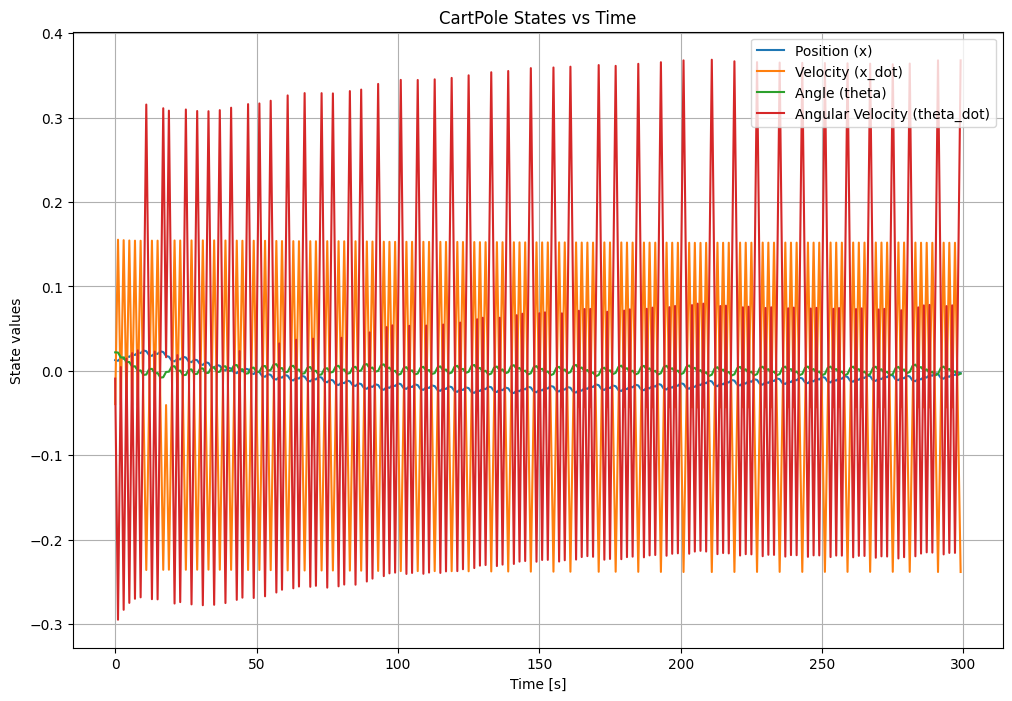

In [16]:
import matplotlib.pyplot as plt
# Convert to NumPy array for easy slicing
states = np.array(states)
times = np.array(times)

# Plot each state vs time
plt.figure(figsize=(12, 8))
state_labels = ["Position (x)", "Velocity (x_dot)", "Angle (theta)", "Angular Velocity (theta_dot)"]

for i in range(4):
    plt.plot(times, states[:, i], label=state_labels[i])
# plt.plot(times, states[:, 0], label=state_labels[0])
# plt.plot(times, states[:, 2], label=state_labels[2])

plt.xlabel("Time [s]")
plt.ylabel("State values")
plt.title("CartPole States vs Time")
plt.legend()
plt.grid(True)
plt.show()

## LQI

In [9]:
A_a = np.zeros((5, 5))
A_a[0, 1] = -1       # integrator: dz/dt = -(p)
A_a[1:, 1:] = A

B_a = np.zeros((5, 1))
B_a[1:, :] = B


In [10]:
Q = np.diag([5,   # integral error
             1,   # position
             1,   # velocity
             30,  # angle
             10]) # angular velocity

R = np.array([[0.001]])


In [11]:
from scipy.linalg import solve_continuous_are

P = solve_continuous_are(A_a, B_a, Q, R)
K = np.linalg.inv(R) @ (B_a.T @ P)

print("LQI gain:", K)


LQI gain: [[  70.71067812 -135.86225352 -123.45060461 -610.55550163 -165.61285871]]


In [12]:
# z = 0.0
# z += -x_pos * dt     # integrator update
# x_aug = np.array([z, x_pos, x_dot, theta, theta_dot])
# u = -K @ x_aug

In [13]:
z = 0.0
def lqi_controller(K, obs):
    global z

    x_pos      = obs[0]
    x_dot      = obs[1]
    theta      = obs[2]
    theta_dot  = obs[3]

    dt = 0.02

    # update integrator
    z += -x_pos * dt

    # optional: anti-windup
    z = np.clip(z, -2.0, 2.0)

    # augmented state
    x_aug = np.array([z, x_pos, x_dot, theta, theta_dot])

    # control
    u = float(-K @ x_aug)

    if u > 0:
        return 1, u     # if force_dem > 0 -> move cart right
    else:
        return 0, u     # if force_dem <= 0 -> move cart left

In [14]:
env = gym.make('CartPole-v1')
# env.env.seed(1)     # seed for reproducibility
obs, info = env.reset()
states = []
times = []
dt = 0.2  # from cartpole github
t = 0.0
max_steps = 300

while True:
    # env.render()          
    
    states.append(obs)
    times.append(t)
    t += 1
    
    action, force = lqi_controller(K, obs)
    # print(K.shape, obs.shape, force.shape)
    
    # absolute value, since 'action' determines the sign, F_min = -10N, F_max = 10N
    abs_force = abs(float(np.clip(force, -10, 10)))
    # abs_force = abs(float(force))
    
    # # change magnitude of the applied force in CartPole
    env.env.force_mag = abs_force

    # apply action
    obs, reward, terminated, truncated, info = env.step(action)
    # done = terminated or truncated
    if terminated:
        print(f'Terminated on falling at timestep: {t}.')
        # break
    if t==max_steps:
        print(f"{max_steps} steps in the env without falling.")
        break

# env.close()

300 steps in the env without falling.


/tmp/ipykernel_1532616/2808006831.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x_aug)


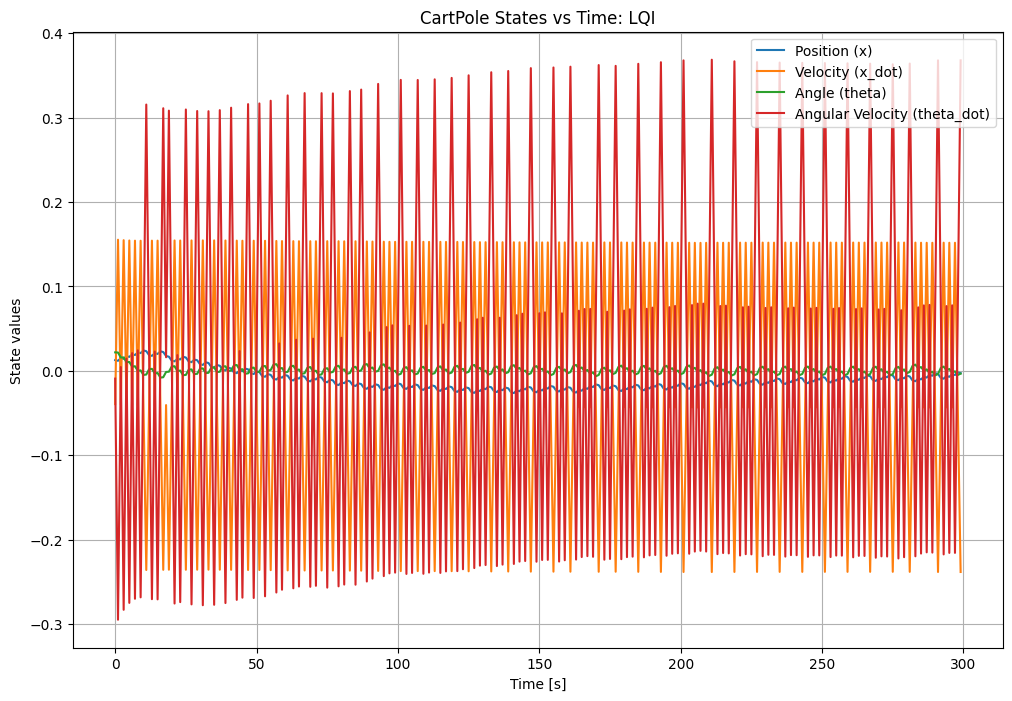

In [15]:
import matplotlib.pyplot as plt
# Convert to NumPy array for easy slicing
states = np.array(states)
times = np.array(times)

# Plot each state vs time
plt.figure(figsize=(12, 8))
state_labels = ["Position (x)", "Velocity (x_dot)", "Angle (theta)", "Angular Velocity (theta_dot)"]

for i in range(4):
    plt.plot(times, states[:, i], label=state_labels[i])
# plt.plot(times, states[:, 0], label=state_labels[0])
# plt.plot(times, states[:, 2], label=state_labels[2])

plt.xlabel("Time [s]")
plt.ylabel("State values")
plt.title("CartPole States vs Time: LQI")
plt.legend()
plt.grid(True)
plt.show()